**Auswertung zu S301:**

- Reward scheint allgemein kompliziert zu lernen
- Längere Laufzeit hat (einmal wieder) nichts gebracht (Reward wohl wirklich schwer)
- Problem: Es gibt weiterhin viele kleine Setpoint-Änderungen in der Nacht, dies ist nicht erwünscht und am Tag gibt es (trotzdem dass nur ein Raum, SPACE2-1 trainiert wird) immer noch mehr Wunschtemp-Verletzungen als in der Baseline (!). Die negativen Reward-Signale von "Fehlern" des Agenten für SPACE2-1 gehen im Vergleich zu den anderen fast unter.

- **Idee: Ein Agent im Brodcast Modus**

**Auswertung zu s302:**

- same problems as for s301, so it might be good to change the reward
- **Idea:** instead of current energy consumption **use differential of energy consumption and clip this**, see last cells for a good clipping value (+/- 80 seems to be good)

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/b001/",
            "../checkpoints/s301/20210601-2225/",
            "../checkpoints/s301-faster/20210601-2228/",
            "../checkpoints/s302/20210604-1213/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
q_values = vh.load_and_convert_q_values(dirnames)

No Q-value list found for ../checkpoints/b001/.


In [9]:
vh.get_arguments_overview(dirnames)

,b001,s301,s301-faster,s302
algorithm,baseline_rule-based,ddqn,ddqn,ddqn
lr,0.01,0.1,0.1,0.1
batch_size,128,256,256,256
lambda_rwd_mstpc,0.1,0.1,0.1,0.16
lambda_rwd_energy,5e-06,0.006,0.006,0.017
reward_offset,0.0,0.3,0.3,0.3
stp_reward_step_offset,0.0,1.0,1.0,1.0
target_network_update_freq,3,2,2,2
epsilon_final_step,100,24480,16000,16000
epsilon_decay_mode,exponential,linear,linear,linear


In [10]:
vh.get_runtime_overview_df(alldfs, dirnames)

,b001,s301,s301-faster,s302
Number of training episodes,1.0,24480.000000,16000.000000,16000.000000
Runtime in s,0.0,113068.356349,74092.132365,63250.584973
Runtime in h,0.0,31.407877,20.581148,17.569607
Mean episode runtime in s,0.0,4.618805,4.630758,3.953162
Mean episode runtime during eval. episode in s,0.0,4.814397,4.820689,4.120984
Mean episode runtime after eval. episode in s,NaN,4.553834,4.541834,3.902016
Mean episode runtime in no eval. episode in s,NaN,4.617575,4.629564,3.952106


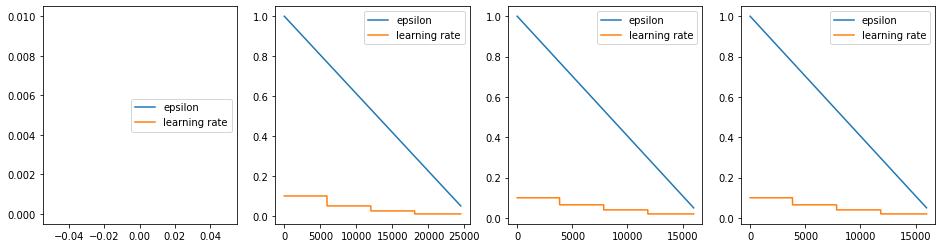

In [11]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

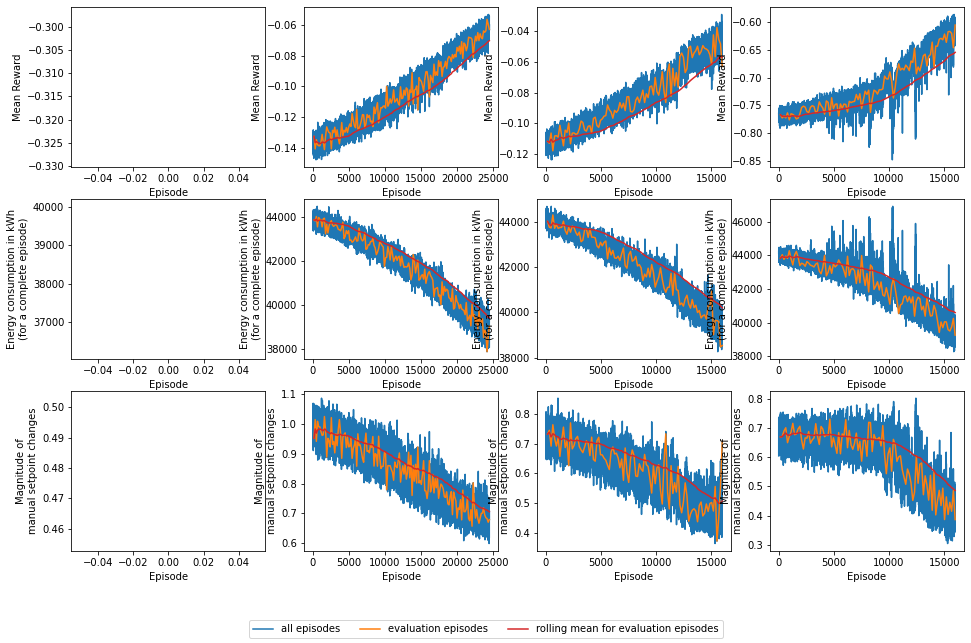

In [12]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

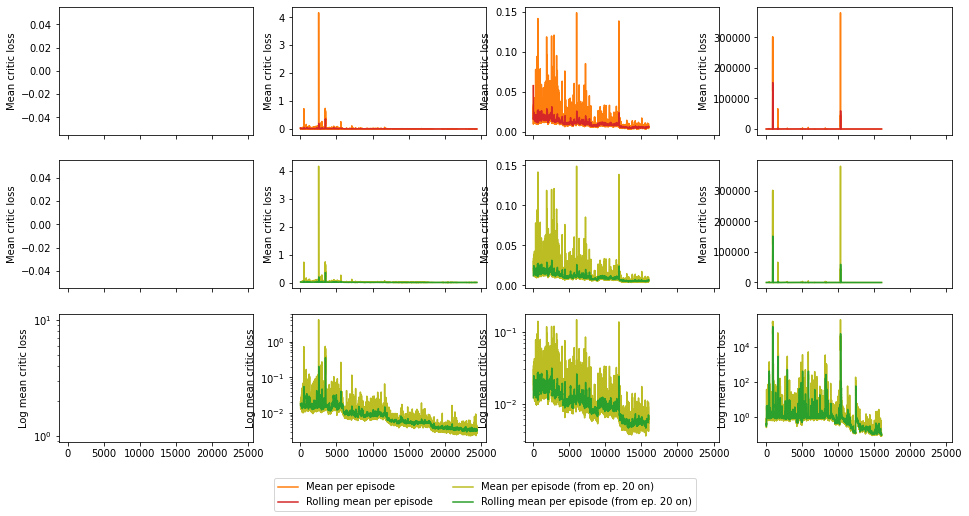

In [13]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

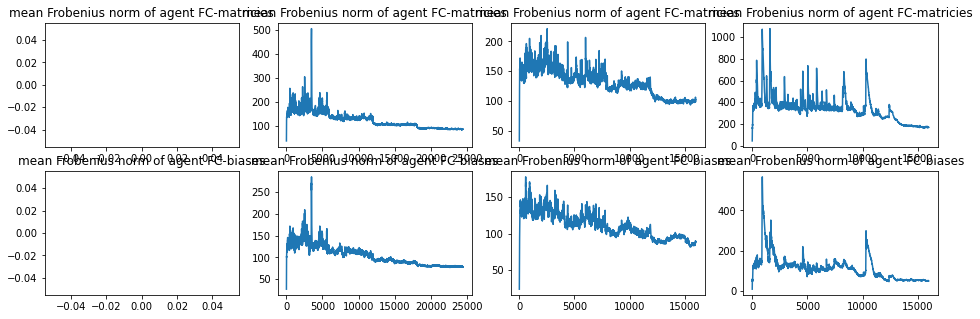

In [14]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [15]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:      0
Last available evaluation episode for dfs1:  24479
Last available evaluation episode for dfs2:  15999
Last available evaluation episode for dfs3:  15999


<h3>Details for one week</h3>

In [16]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [17]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [18]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode     0: Energy consumption:   38118.41 kWh; Numer of setpoint changes: 344.43972940869935
For episode 24479: Energy consumption:   39034.07 kWh; Numer of setpoint changes: 488.4103143331273
For episode 15999: Energy consumption:   38535.25 kWh; Numer of setpoint changes: 508.15915303705805
For episode 15999: Energy consumption:   39256.84 kWh; Numer of setpoint changes: 277.6247950711309

Mean values for episode ...
...     0: Reward: -0.31298 kWh; Setpoint change magnit.:  0.47905; Energy cons.: 53015.87025
... 24479: Reward: -0.06274 kWh; Setpoint change magnit.:  0.67929; Energy cons.: 54289.38213
... 15999: Reward: -0.06290 kWh; Setpoint change magnit.:  0.70676; Energy cons.: 53595.61979
... 15999: Reward: -0.60543 kWh; Setpoint change magnit.:  0.38613; Energy cons.: 54599.22642


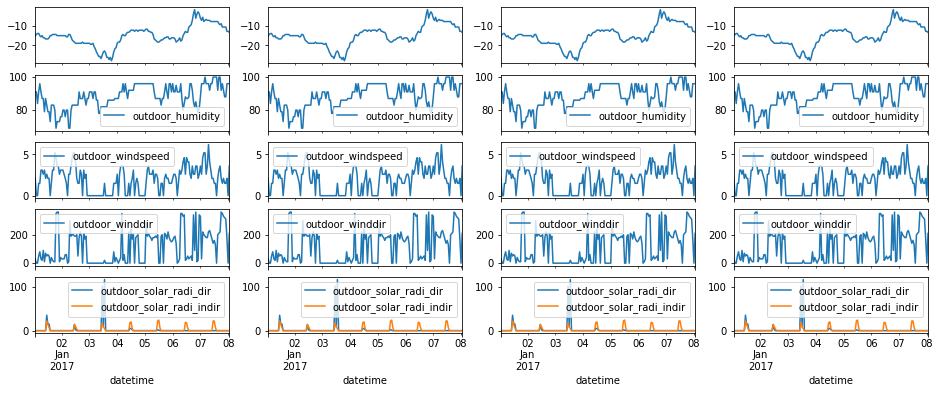

In [19]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

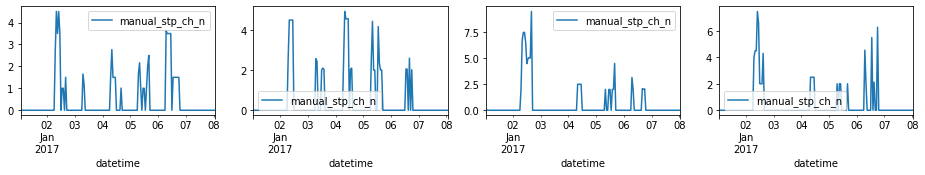

In [20]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

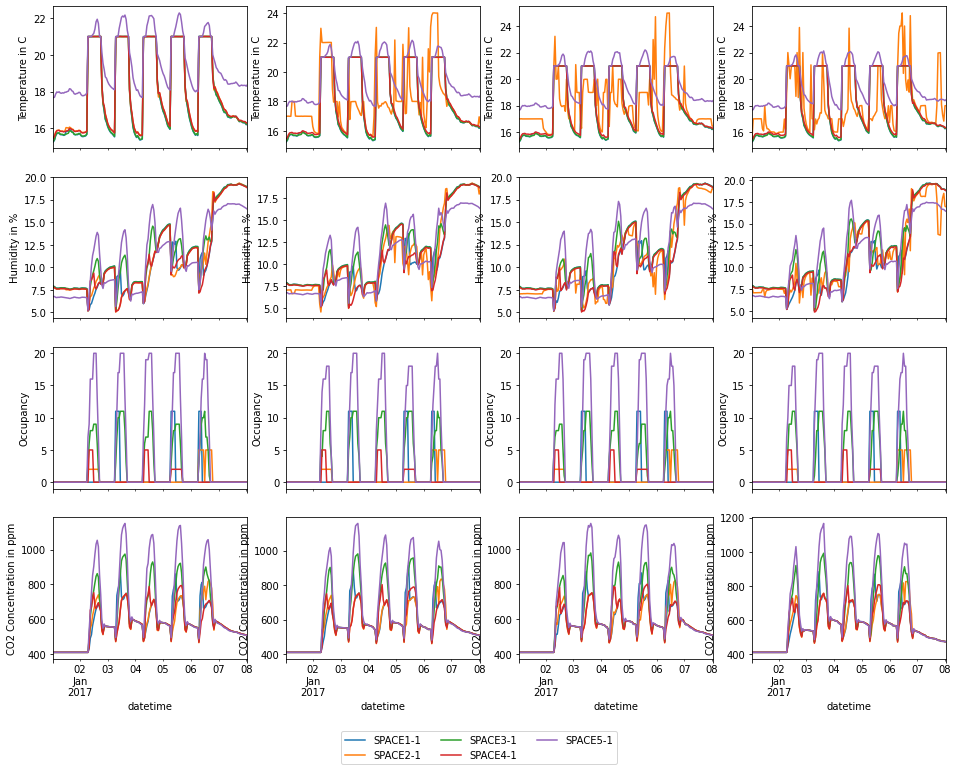

In [21]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [22]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: {'SPACE2-1': 0, 'SPACE5-1': 1, 'SPACE4-1': 2, 'SPACE3-1': 3, 'SPACE1-1': 4} 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: {'SPACE2-1': 0, 'SPACE5-1': 1, 'SPACE4-1': 2, 'SPACE3-1': 3, 'SPACE1-1': 4} 

Available Rooms     in (sub-)dfs3: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs3: {'SPACE2-1': 0, 'SPACE5-1': 1, 'SPACE4-1': 2, 'SPACE3-1': 3, 'SPACE1-1': 4} 



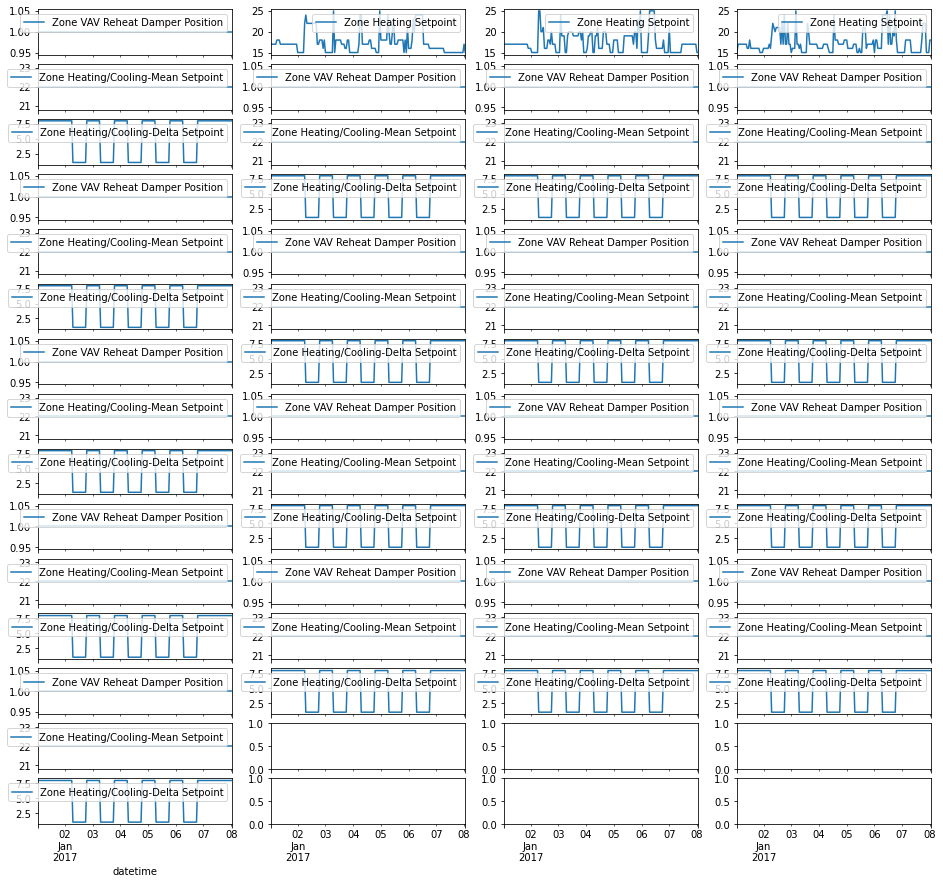

In [23]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

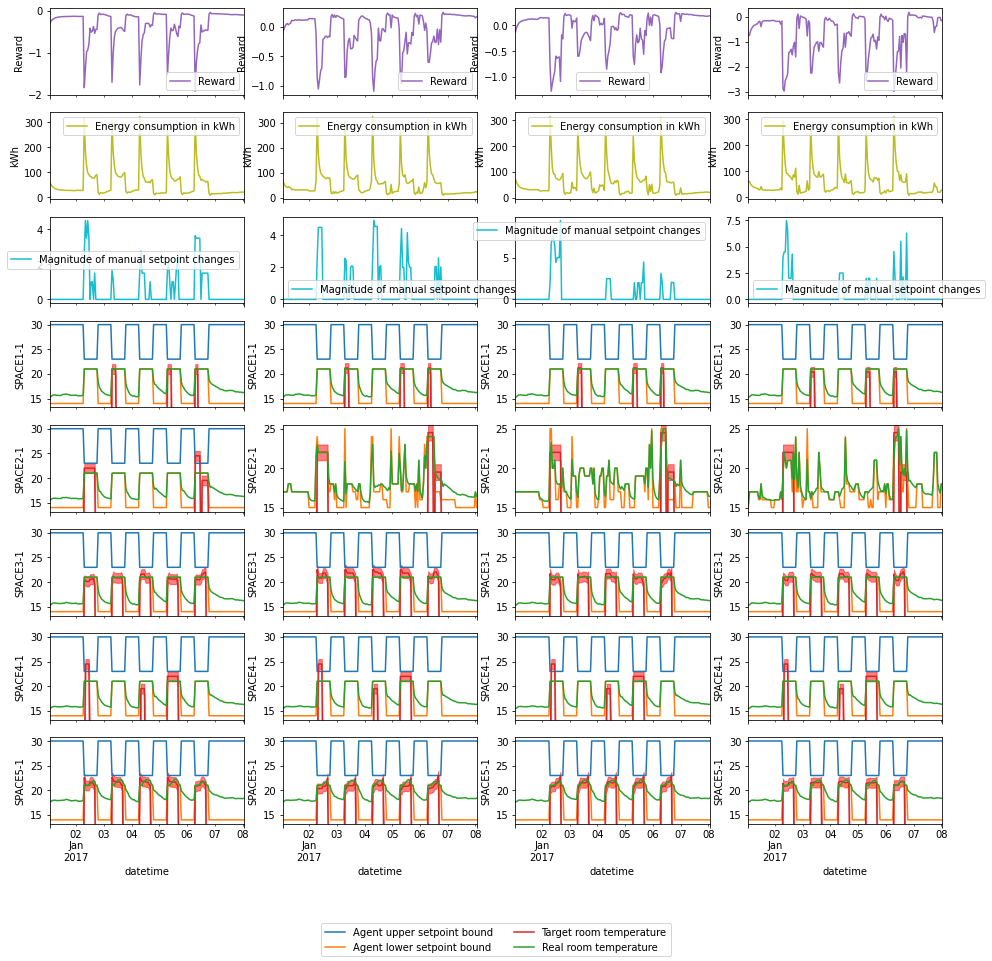

In [24]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [25]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [26]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

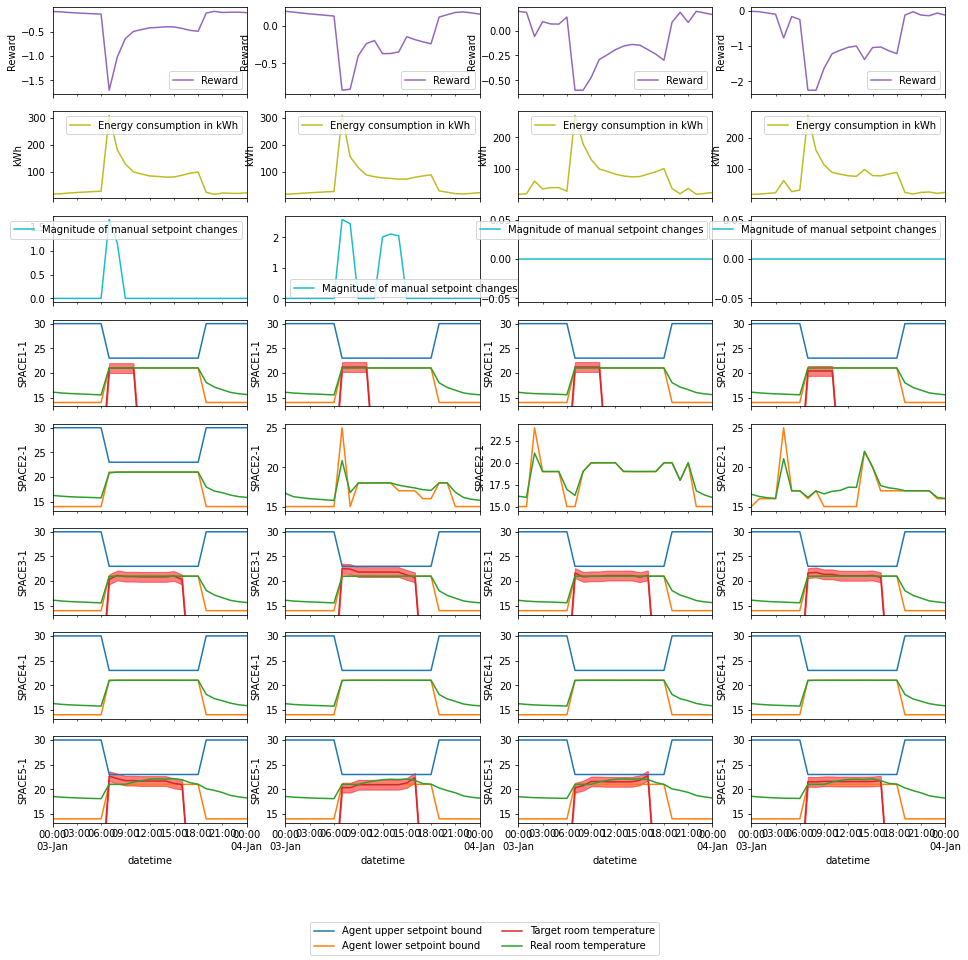

In [27]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [28]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [29]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

For plot number 1, mean energy consumption =  52110.2 Wh, mean reward = -0.3067
For plot number 2, mean energy consumption =  53406.7 Wh, mean reward = -0.0581
For plot number 3, mean energy consumption =  52731.2 Wh, mean reward = -0.0512
For plot number 4, mean energy consumption =  53588.9 Wh, mean reward = -0.5892


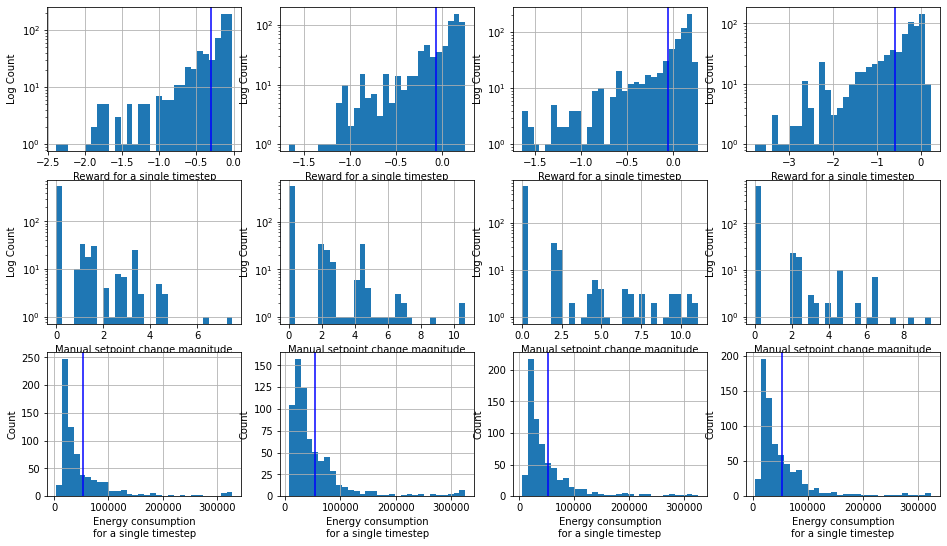

In [30]:
vh.plot_stpch_and_econs_distrib(subdfs, fig_width)

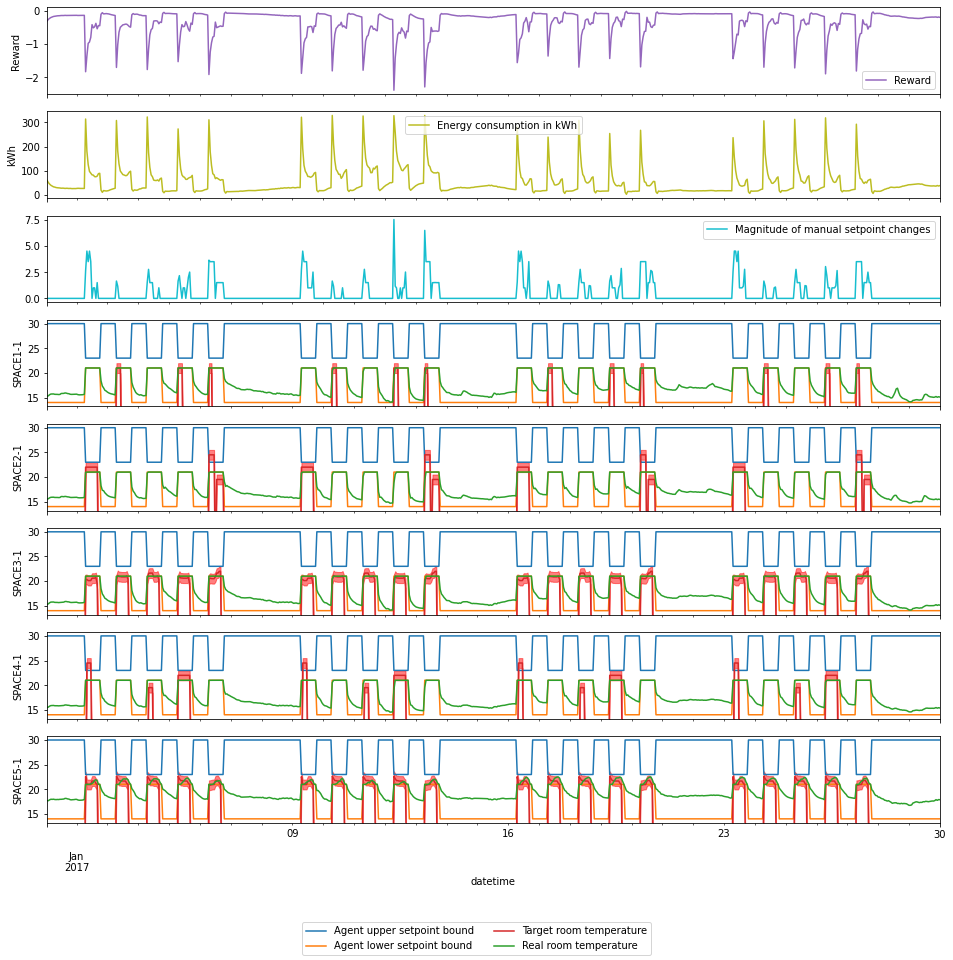

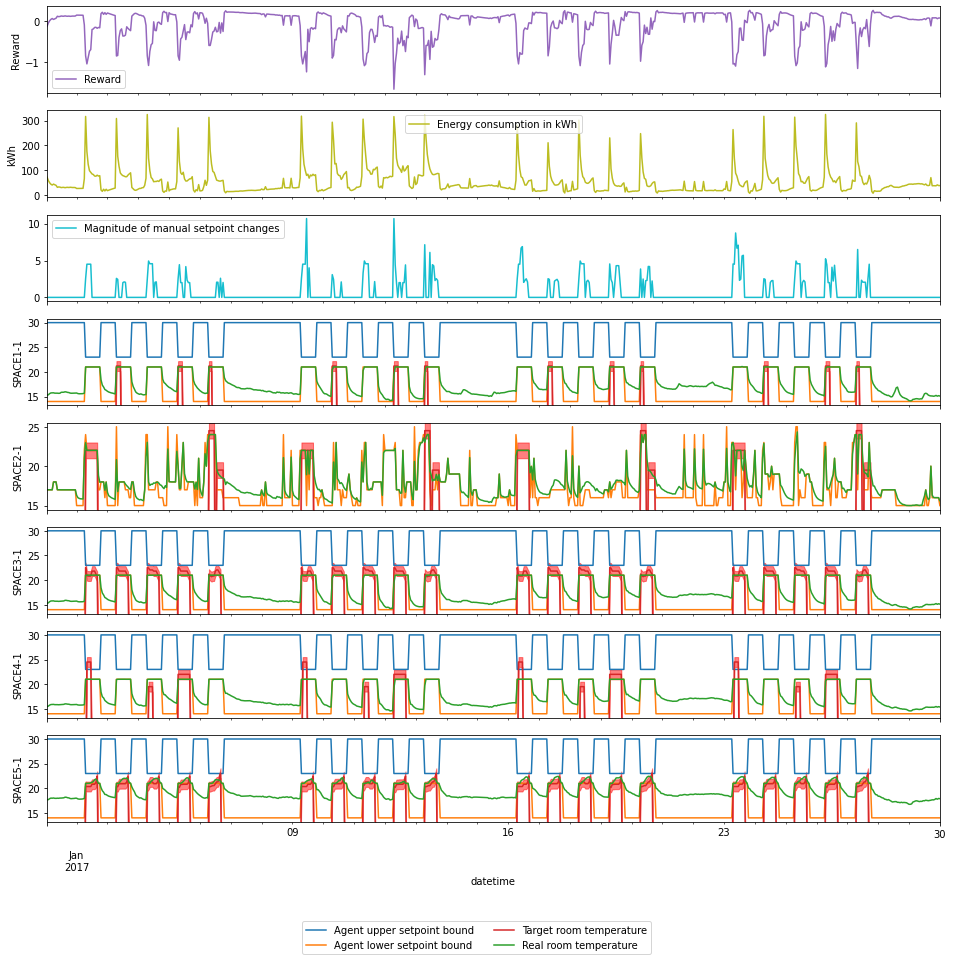

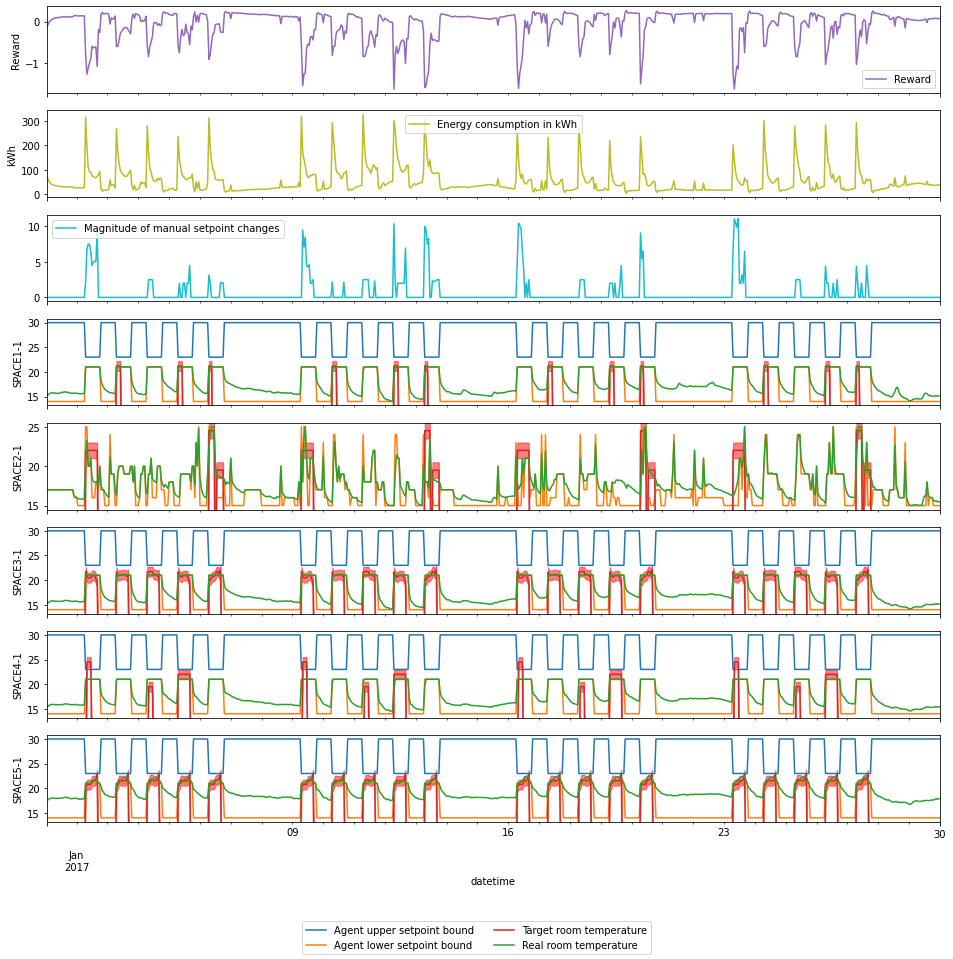

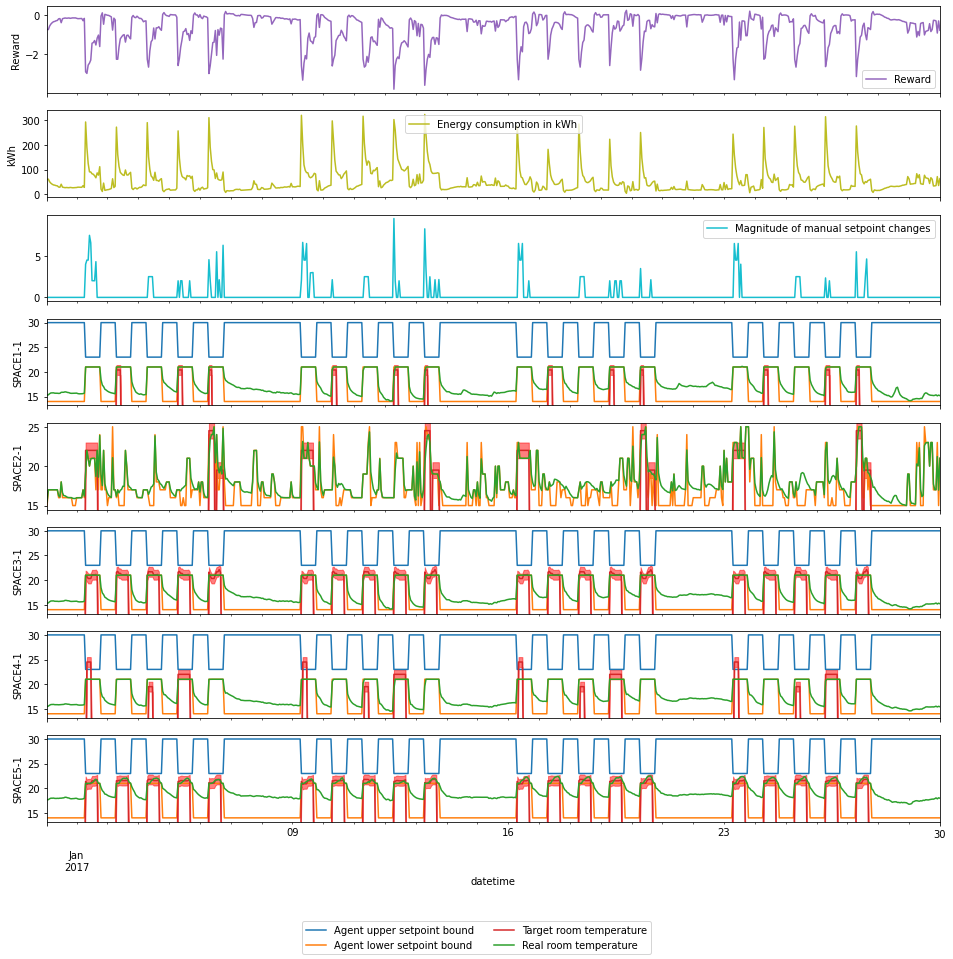

In [31]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

No q-values available for scenario 1: s301, agent 1
No q-values available for scenario 1: s301, agent 2
No q-values available for scenario 1: s301, agent 3
No q-values available for scenario 1: s301, agent 4
No q-values available for scenario 2: s301-faster, agent 1
No q-values available for scenario 2: s301-faster, agent 2
No q-values available for scenario 2: s301-faster, agent 3
No q-values available for scenario 2: s301-faster, agent 4
No q-values available for scenario 3: s302, agent 1
No q-values available for scenario 3: s302, agent 2
No q-values available for scenario 3: s302, agent 3
No q-values available for scenario 3: s302, agent 4


(<Figure size 1152x648 with 6 Axes>,
 array([<AxesSubplot:ylabel='Scenario 1: s301\nAgent 0'>,
        <AxesSubplot:ylabel='Scenario 2: s301-faster\nAgent 0'>,
        <AxesSubplot:ylabel='Scenario 3: s302\nAgent 0'>], dtype=object))

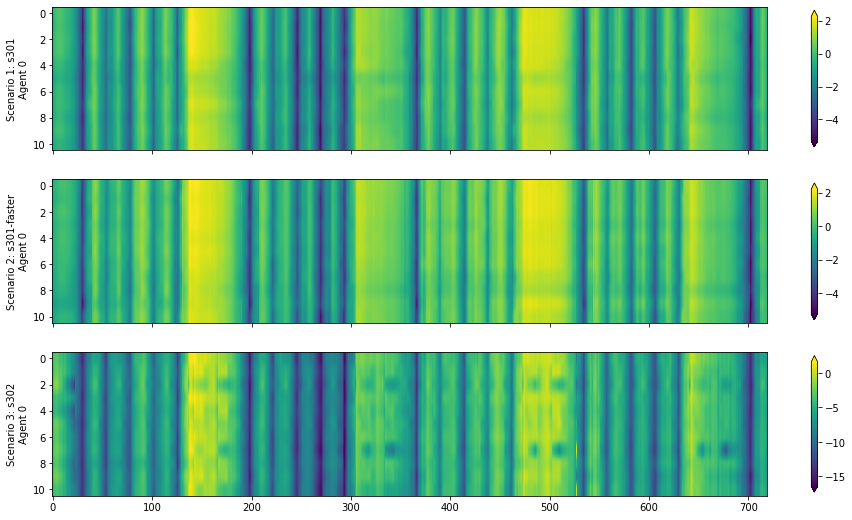

In [32]:
vh.plot_q_values(q_values, fig_width)

<h3>Reward analysis</h3> for s302

In [60]:
clip_level_1 = 125
clip_level_2 = 80

In [61]:
econs = subdfs[-1]['sees'].loc[:, 'energy_Wh']/1000
econs_clipped = econs.clip(0,150)
econs_diff    = econs.diff(periods = 1)
econs_diff_cl = econs_diff.clip(-clip_level_1,clip_level_1)
econs_diff_cl2= econs_diff.clip(-clip_level_2,clip_level_2)
#orig_from_clipped_diff = econs_diff_cl.cumsum()

<AxesSubplot:>

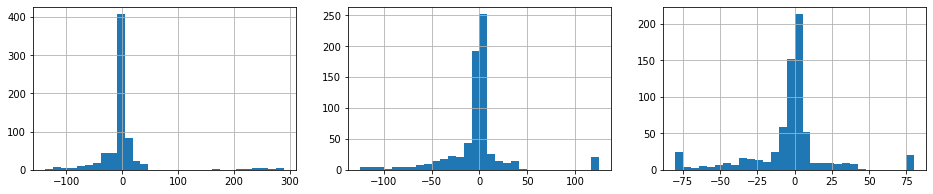

In [62]:
_, ax = plt.subplots(nrows=1,ncols=3, figsize=(fig_width, 3))
econs_diff.hist(bins=30,ax=ax[0])
econs_diff_cl.hist(bins=30,ax=ax[1])
econs_diff_cl2.hist(bins=30,ax=ax[2])

(-80.0, 80.0)

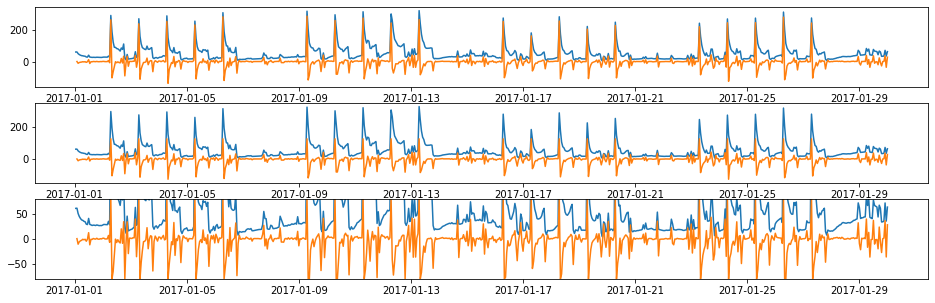

In [64]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(fig_width, 5))
ax[0].plot(econs)
ax[0].plot(econs_diff)
ax[1].plot(econs)
ax[1].plot(econs_diff_cl)
ax[2].plot(econs)
ax[2].plot(econs_diff_cl2)
ax[2].set_ylim(-clip_level_2, clip_level_2)